<h3>Importing Packages</h3>

In [43]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import wget
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC
import seaborn as sns
from matplotlib import pyplot as plt
import torch
import transformers
from transformers import AutoModel, AutoTokenizer
from scipy import spatial

<h3>Loading input data</h3>

In [32]:
df_clinnotes = pd.read_csv("ClinNotes.csv")

In [33]:
df_medicalconcept = pd.read_csv("MedicalConcepts.csv")

In [59]:
# BERT Model
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased') #, do_lower_case=True, do_basic_tokenize=True
model = AutoModel.from_pretrained('bert-large-uncased', output_hidden_states=True)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<h3>Bert Embedding</h3>

In [71]:
class BERTEmbedding():
    def __init__(self):
        self.tokens = ""
        self.sentence_tokens = ""
        self.tokenizer = tokenizer
        self.model = model

    def bert_tokenization(self,text):
        # creating text data in required format
        marked_text = "[CLS] "+ text + "[ SEP]"
        # spliting the sentence into tokens
        tokenized_text = tokenizer.tokenize(marked_text)
        return tokenized_text

    def create_token_mapping(self,tokenized_text):
        # mapping the token strings to their vocabulary indeces.
        indexed_tokens= tokenizer.convert_tokens_to_ids(tokenized_text)
        # marking each of the 22 tokens as belonging to sentence 1
        segments_ids= [1] * len(tokenized_text)

        #converting inputs to pytorch tensors
        tokens_tensor= torch.tensor([indexed_tokens])
        segments_tensors= torch.tensor([segments_ids])
        # putting the model in evaluaion mode
        model.eval()

        # running the text through Bert, and collecting all of the hidden states produced by the layers.
        with torch.no_grad():
            outputs=model(tokens_tensor,segments_tensors)
            hidden_states=outputs[2]

        return hidden_states  

    def get_word_vector(self,text):
        tokenized_text = self.bert_tokenization(text)

        hidden_states = self.create_token_mapping(tokenized_text)
        # combining the layers to making one big vector
        token_embeddings= torch.stack(hidden_states,dim=0) 

        # Removing dimension 1 from the batches.
        token_embeddings = torch.squeeze(token_embeddings, dim=1)

        # Swaping the dimensions 0 and 1.
        token_embeddings = token_embeddings.permute(1,0,2)  


        token_vecs_sum = []

        for token in token_embeddings:
            # token is a [12 x 768] tensor
            # Sum the vectors from the last four layers.
            sum_vec = torch.sum(token[-4:], dim=0)
            # appending the vectors values in dict
            token_vecs_sum.append(sum_vec)

        #calculating the mean of the tensor
        mean = torch.mean(torch.stack(token_vecs_sum),dim=-2)
        # converting tensor to numpy array
        mean = mean.detach().numpy()
        return mean

    def get_sentence_vector(self,text):
        marked_text = "[CLS] "+ text + "[ SEP]"
        tokenized_text = self.bert_tokenization(text)[:512]
        hidden_states = self.create_token_mapping(tokenized_text)
        # token_vecs is a tensor with shape [22 x 768]
        token_vecs = hidden_states[-2][0]
        # Calculating the average of all token vectors.
        sentence_embedding = torch.mean(token_vecs, dim=0)
        # converting the tensor to numpy array
        sentence_embedding=sentence_embedding.detach().numpy()
        return sentence_embedding

In [73]:
# calculating word vector for single word
text = "Glaucoma"
bert_model = BERTEmbedding()
word_vector = bert_model.get_word_vector(text)

In [62]:
word_vector

array([-3.5140185 , -2.6454067 , -0.87413967, ...,  2.1172893 ,
        2.8381119 ,  3.6507912 ], dtype=float32)

In [63]:
# calculating the word vector of the all the terms
df_medicalconcept['bert_embedding_term1'] = df_medicalconcept['Term1'].apply(lambda x: bert_model.get_word_vector(x))
df_medicalconcept['bert_embedding_term2'] = df_medicalconcept['Term2'].apply(lambda x: bert_model.get_word_vector(x))

In [64]:
df_medicalconcept.head()

,Term1,Term2,bert_embedding_term1,bert_embedding_term2,cosine_similarity
0,Glaucoma,Fibrillation,"[-3.5140185, -2.6454067, -0.87413967, -0.46554...","[-2.7083907, -3.4811642, -0.7629569, 1.0560955...",0.871441
1,Carbatrol,Dilantin,"[-2.6614735, -2.0590873, -1.7914397, 0.6470068...","[-2.532657, -2.9835286, -1.5824735, 0.15296777...",0.812776
2,Cardiomyopathy,Tylenol,"[-3.0159822, -2.0221212, -2.9911427, -0.695508...","[-3.628576, -2.5959907, -1.3957688, 0.08992670...",0.817618
3,Herpes,Hyperthyroidism,"[-2.78776, -2.5111175, -1.7512555, 0.33207077,...","[-2.3670392, -2.159456, -2.382085, -0.59684986...",0.790684
4,Seasickness,Nausea,"[-2.5917146, -3.334326, -2.1953273, 0.9285096,...","[-2.1828365, -2.234159, -2.4591382, 1.6850199,...",0.782326


In [65]:
df_medicalconcept['cosine_similarity'] = df_medicalconcept.apply(lambda x: 1 - spatial.distance.cosine(x['bert_embedding_term1'], x['bert_embedding_term2']), axis=1)

In [66]:
df_medicalconcept.head()

,Term1,Term2,bert_embedding_term1,bert_embedding_term2,cosine_similarity
0,Glaucoma,Fibrillation,"[-3.5140185, -2.6454067, -0.87413967, -0.46554...","[-2.7083907, -3.4811642, -0.7629569, 1.0560955...",0.894104
1,Carbatrol,Dilantin,"[-2.6614735, -2.0590873, -1.7914397, 0.6470068...","[-2.532657, -2.9835286, -1.5824735, 0.15296777...",0.921481
2,Cardiomyopathy,Tylenol,"[-3.0159822, -2.0221212, -2.9911427, -0.695508...","[-3.628576, -2.5959907, -1.3957688, 0.08992670...",0.879889
3,Herpes,Hyperthyroidism,"[-2.78776, -2.5111175, -1.7512555, 0.33207077,...","[-2.3670392, -2.159456, -2.382085, -0.59684986...",0.883667
4,Seasickness,Nausea,"[-2.5917146, -3.334326, -2.1953273, 0.9285096,...","[-2.1828365, -2.234159, -2.4591382, 1.6850199,...",0.844041


In [87]:
df_medicalconcept['cosine_similarity'].mean()

0.8335796176018226

In [68]:
df_medicalconcept.to_csv("medical_concept_similarity_bert_large.csv", index=False)

<h3>Clean Text</h3>

In [69]:
stop_words = stopwords.words('english')
#removing stop words
df_clinnotes['clean_notes'] = df_clinnotes['notes'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in (stop_words)]))
#removing puntuation
df_clinnotes["clean_notes"] = df_clinnotes['clean_notes'].str.replace('[^\w\s]','', regex=True)
#lemetizing the text
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])
df_clinnotes['clean_notes'] = df_clinnotes['clean_notes'].apply(lemmatize_text)

In [74]:
#get sentence vector for all notes
df_clinnotes['sentence_embedding'] = df_clinnotes['clean_notes'].apply(lambda x: bert_model.get_sentence_vector(str(x)))

Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors


<h3>Splitting Training and Test data</h3>

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df_clinnotes.sentence_embedding, df_clinnotes.category, test_size=0.2, random_state=42)


In [78]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

<h3>Performing Cross Validation on Various ML Algorithms</h3>

In [79]:
models = [
    RandomForestClassifier(n_estimators=500, random_state=42, min_samples_split=3, min_samples_leaf=2),
    LinearSVC(),
    XGBClassifier(learning_rate =0.07,n_estimators=100),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, np.array(X_train.tolist()), y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Lib

[13:27:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [80]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.679389
1,RandomForestClassifier,1,0.641221
2,RandomForestClassifier,2,0.610687
3,RandomForestClassifier,3,0.687023
4,RandomForestClassifier,4,0.653846
5,LinearSVC,0,0.816794
6,LinearSVC,1,0.748092
7,LinearSVC,2,0.824427
8,LinearSVC,3,0.801527
9,LinearSVC,4,0.830769


<h3>Plotting Cross Validation result</h3>

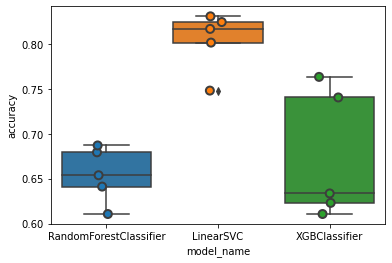

In [81]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

<h3>Evaluating various models</h3>

In [82]:
rf_clf = RandomForestClassifier(n_estimators=500, random_state=42, min_samples_split=3, min_samples_leaf=2, )
rf_clf.fit(np.array(X_train.tolist()), y_train)
print_score(rf_clf, np.array(X_train.tolist()), y_train, np.array(X_test.tolist()), y_test, train=True)
print_score(rf_clf, np.array(X_train.tolist()), y_train, np.array(X_test.tolist()), y_test, train=False)

Train Result:
Accuracy Score: 99.39%
_______________________________________________
CLASSIFICATION REPORT:
           Cardiovascular / Pulmonary  Gastroenterology   Neurology  accuracy  \
precision                    0.989933          1.000000    0.994413  0.993884   
recall                       1.000000          0.983333    0.994413  0.993884   
f1-score                     0.994941          0.991597    0.994413  0.993884   
support                    295.000000        180.000000  179.000000  0.993884   

            macro avg  weighted avg  
precision    0.994782      0.993930  
recall       0.992582      0.993884  
f1-score     0.993650      0.993876  
support    654.000000    654.000000  
_______________________________________________
Confusion Matrix: 
 [[295   0   0]
 [  2 177   1]
 [  1   0 178]]

Test Result:
Accuracy Score: 58.54%
_______________________________________________
CLASSIFICATION REPORT:
           Cardiovascular / Pulmonary  Gastroenterology  Neurology  accura

In [83]:
lsvc_clf = LinearSVC(C=1.0) #n_jobs=4,
lsvc_clf.fit(np.array(X_train.tolist()), y_train)
print_score(lsvc_clf, np.array(X_train.tolist()), y_train, np.array(X_test.tolist()), y_test, train=True)
print_score(lsvc_clf, np.array(X_train.tolist()), y_train, np.array(X_test.tolist()), y_test, train=False)

Train Result:
Accuracy Score: 99.39%
_______________________________________________
CLASSIFICATION REPORT:
           Cardiovascular / Pulmonary  Gastroenterology   Neurology  accuracy  \
precision                    0.993243          0.994413    0.994413  0.993884   
recall                       0.996610          0.988889    0.994413  0.993884   
f1-score                     0.994924          0.991643    0.994413  0.993884   
support                    295.000000        180.000000  179.000000  0.993884   

            macro avg  weighted avg  
precision    0.994023      0.993886  
recall       0.993304      0.993884  
f1-score     0.993660      0.993881  
support    654.000000    654.000000  
_______________________________________________
Confusion Matrix: 
 [[294   1   0]
 [  1 178   1]
 [  1   0 178]]

Test Result:
Accuracy Score: 72.56%
_______________________________________________
CLASSIFICATION REPORT:
           Cardiovascular / Pulmonary  Gastroenterology  Neurology  accura

/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [84]:
xgb_clf = XGBClassifier(n_estimators=100, enable_categorical=True) #n_jobs=4,
xgb_clf.fit(np.array(X_train.tolist()), y_train)
print_score(xgb_clf, np.array(X_train.tolist()), y_train, np.array(X_test.tolist()), y_test, train=True)
print_score(xgb_clf, np.array(X_train.tolist()), y_train, np.array(X_test.tolist()), y_test, train=False)

/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:28:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:28:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Result:
Accuracy Score: 99.39%
_______________________________________________
CLASSIFICATION REPORT:
           Cardiovascular / Pulmonary  Gastroenterology   Neurology  accuracy  \
precision                    0.989933          0.994413    1.000000  0.993884   
recall                       1.000000          0.988889    0.988827  0.993884

<h3>Results</h3>
1. Vector representation for all the medical concepts words generated using Pretrained Bio Bert. <br>
2. Resulted embedded vector used for Clinical notes classification. Performance is lower as compare to Word2Vec model